In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import cv2
!pip install opendatasets --upgrade --quiet
import opendatasets as od
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
#from keras.layers.merge import concatenate
from tensorflow.keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imutils import paths
import argparse

In [2]:
from google.colab import drive
drive.mount('/content/drive')
dataset_url = 'https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?recency=last7Days'
data_dir = '/content/COVID-19_Radiography_Dataset'

Mounted at /content/drive


In [ ]:
# #load training and testing dataset from output directory where the split is fixed for all models
# train_datagen=ImageDataGenerator(rescale = 1./255,
#                                    rotation_range=15,
#                                    fill_mode="nearest",
#                                    horizontal_flip = True)
# valid_datagen=ImageDataGenerator(rescale = 1./255)
# test_datagen=ImageDataGenerator(rescale = 1./255)

# training_set=train_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/train',
#                                                  target_size = (224, 224),
#                                                  batch_size = 64,
#                                                  class_mode = 'categorical',
#                                                  shuffle=True)
# valid_set=valid_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/val',
#                                             target_size = (224, 224),
#                                             batch_size = 64,
#                                             class_mode = 'categorical',
#                                             shuffle = False)Tahsin Mayeesha
# test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/test',
#                                             target_size = (224, 224),
#                                             batch_size = 64,
#                                             class_mode = 'categorical',
#                                             shuffle = False)

In [3]:
!pip install split-folders
import splitfolders
input_folder = '/content/drive/MyDrive/New_DS/Dataset_Covid/COVID-19_Radiography_Dataset'
splitfolders.ratio( input_folder,
                   output="output",seed=1337,ratio=(0.7,0.2,0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 21168 files [08:39, 40.72 files/s] 


In [4]:
#load training and testing dataset from directory
train_datagen=ImageDataGenerator(rescale = 1./255,
                                   rotation_range=15,
                                   fill_mode="nearest",
                                   horizontal_flip = True)
valid_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen=ImageDataGenerator(rescale = 1./255)

training_set=train_datagen.flow_from_directory('/content/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
valid_set=valid_datagen.flow_from_directory('/content/output/val',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)
test_set=test_datagen.flow_from_directory('/content/output/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 14816 images belonging to 4 classes.
Found 4233 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.


In [5]:
print(training_set.class_indices)
print(valid_set.class_indices)
print(test_set.class_indices)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


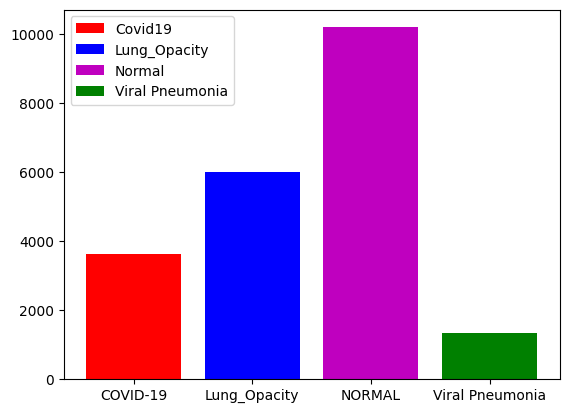

In [6]:
#visulaize data
fig, ax = plt.subplots()
ax.bar("COVID-19",3616,color="r",label="Covid19")
ax.bar("Lung_Opacity",6012 ,color="b",label="Lung_Opacity")
ax.bar("NORMAL",10192,color="m",label="Normal")
ax.bar("Viral Pneumonia",1345,color="g",label="Viral Pneumonia")
ax.legend()

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, AveragePooling2D, Flatten, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Multiply

def eca_module(inputs):
    channels = inputs.shape[-1]
    gamma = 2.0  # scaling parameter
    t = int(channels // gamma)  # reduction ratio
    x = GlobalAveragePooling2D()(inputs)  # global average pooling
    x = Dense(t, activation="relu")(x)  # reduce dimensionality
    x = Dense(channels, activation="sigmoid")(x)  # channel attention
    x = Multiply()([inputs, x])  # apply channel attention
    return x

baseModel = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

vgg_model = baseModel.output
vgg_model = AveragePooling2D()(vgg_model)

# Add ECA Module in the middle deep layer
eca_block = eca_module(vgg_model)
vgg_model = tf.keras.layers.concatenate([vgg_model, eca_block])  # Concatenate the ECA block output with the previous layer

vgg_model = Flatten()(vgg_model)
vgg_model = Dense(4096, activation='relu')(vgg_model)
vgg_model = Dropout(0.5)(vgg_model)
vgg_model = Dense(4096, activation='relu')(vgg_model)
vgg_model = Dropout(0.5)(vgg_model)
vgg_model = Dense(1000, activation='relu')(vgg_model)
vgg_model = Dropout(0.5)(vgg_model)
vgg_model = Dense(4, activation='softmax')(vgg_model)

VGG16_MODEL = Model(inputs=baseModel.input, outputs=vgg_model)

# Compile the model
VGG16_MODEL.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy', 'Precision', 'Recall'])
VGG16_MODEL.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                             

In [12]:
tf.keras.callbacks.ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

epochs = 5
initial_learning_rate=0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=initial_learning_rate / epochs)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [13]:
from sklearn.model_selection import KFold
import numpy as np

# Define the number of folds
num_folds = 5

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store the accuracy of each fold
fold_accs = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(training_set)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Create a new instance of the VGG16 model for each fold
    # VGG16_MODEL = create_vgg16_model()

    # Compile the model
    VGG16_MODEL.compile(optimizer=optimizer,
                        loss='categorical_crossentropy',
                        metrics=['accuracy', 'Precision', 'Recall'])

    # Split the data into training and validation sets for the current fold
    # X_train, y_train = training_set
    # X_val, y_val = valid_set

    # Train the model
    history = VGG16_MODEL.fit(training_set,
                              validation_data=valid_set,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[early])

    # Evaluate the model on the validation set
    _, accuracy, precision, recall = VGG16_MODEL.evaluate(test_set)
    fold_accs.append(accuracy)

# Calculate and print the average accuracy across all folds
mean_acc = np.mean(fold_accs)
print("Average accuracy:", mean_acc)

Fold 1/5
Epoch 1/5
232/232 [==============================] - 233s 986ms/step - loss: 0.4697 - accuracy: 0.8261 - precision: 0.8523 - recall: 0.7985 - val_loss: 0.3480 - val_accuracy: 0.8786 - val_precision: 0.8941 - val_recall: 0.8613
Epoch 2/5
232/232 [==============================] - 228s 983ms/step - loss: 0.4565 - accuracy: 0.8318 - precision: 0.8625 - recall: 0.7961 - val_loss: 0.3283 - val_accuracy: 0.8781 - val_precision: 0.8904 - val_recall: 0.8677
Epoch 3/5
232/232 [==============================] - 231s 994ms/step - loss: 0.4315 - accuracy: 0.8426 - precision: 0.8671 - recall: 0.8132 - val_loss: 0.3416 - val_accuracy: 0.8838 - val_precision: 0.9013 - val_recall: 0.8627
Epoch 4/5
232/232 [==============================] - 237s 1s/step - loss: 0.3925 - accuracy: 0.8570 - precision: 0.8765 - recall: 0.8346 - val_loss: 0.3580 - val_accuracy: 0.8892 - val_precision: 0.9112 - val_recall: 0.8601
Epoch 5/5
34/34 [==============================] - 11s 321ms/step - loss: 0.3575 - acc

In [ ]:
# VGG16_MODEL.compile(optimizer = optimizer,
#               loss='categorical_crossentropy',
#               metrics=['accuracy','Precision','Recall'])
# history = VGG16_MODEL.fit_generator(training_set, validation_data = valid_set, epochs=epochs, verbose=1, callbacks=[early])

<ipython-input-9-236624b0a79e>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = VGG16_MODEL.fit_generator(training_set, validation_data = valid_set, epochs=epochs, verbose=1, callbacks=[early])


Epoch 1/100
232/232 [==============================] - 290s 1s/step - loss: 0.8487 - accuracy: 0.7079 - precision: 0.7720 - recall: 0.6216 - val_loss: 0.4604 - val_accuracy: 0.8233 - val_precision: 0.8449 - val_recall: 0.7994
Epoch 2/100
232/232 [==============================] - 242s 1s/step - loss: 0.5236 - accuracy: 0.8074 - precision: 0.8377 - recall: 0.7665 - val_loss: 0.3848 - val_accuracy: 0.8604 - val_precision: 0.8816 - val_recall: 0.8372
Epoch 3/100
232/232 [==============================] - 249s 1s/step - loss: 0.4621 - accuracy: 0.8323 - precision: 0.8559 - recall: 0.8018 - val_loss: 0.3707 - val_accuracy: 0.8661 - val_precision: 0.8892 - val_recall: 0.8377
Epoch 4/100
232/232 [==============================] - 240s 1s/step - loss: 0.4155 - accuracy: 0.8494 - precision: 0.8676 - recall: 0.8282 - val_loss: 0.3425 - val_accuracy: 0.8764 - val_precision: 0.8927 - val_recall: 0.8568
Epoch 5/100
232/232 [==============================] - 245s 1s/step - loss: 0.3946 - accuracy: 0

In [14]:
VGG16_MODEL.evaluate(test_set, verbose=1)
#***model.evaluate(test_set)

34/34 [==============================] - 9s 266ms/step - loss: 0.3065 - accuracy: 0.9051 - precision: 0.9128 - recall: 0.8938


[0.30645430088043213,
 0.9051439166069031,
 0.9127711057662964,
 0.8938178420066833]

In [15]:
VGG16_MODEL.save('VGG16.h5')

In [16]:
#Accuracy, val_acc, loss, val_loss, epoch_range
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']     #history2.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

In [17]:
print("accuracy: ",acc)
print("validation accuracy: ",val_acc)
print("loss: ",loss)
print("validation loss: ",val_loss)
print("epochs: ",epochs)

accuracy:  [0.8976781964302063, 0.8935610055923462, 0.8926160931587219, 0.8995680212974548, 0.894573450088501]
validation accuracy:  [0.9038506746292114, 0.9012520909309387, 0.9019607901573181, 0.9026694893836975, 0.9026694893836975]
loss:  [0.2768971621990204, 0.27897170186042786, 0.2783913016319275, 0.2777644097805023, 0.27968618273735046]
validation loss:  [0.30245620012283325, 0.3016536831855774, 0.3001297414302826, 0.30101239681243896, 0.3013268709182739]
epochs:  range(0, 5)


Text(0.5, 1.0, 'Training and Validation Accuracy')

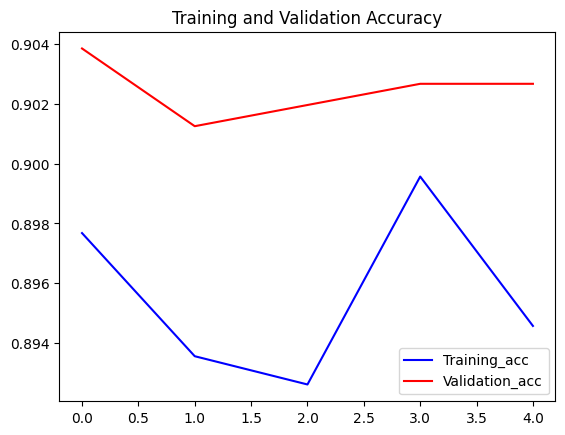

In [18]:
#plot training nad validation accuracy
plt.plot(epochs,acc,label='Training_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

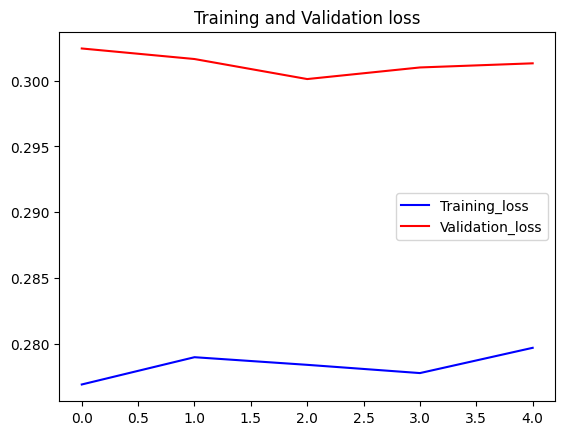

In [19]:
#training and validation loss
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

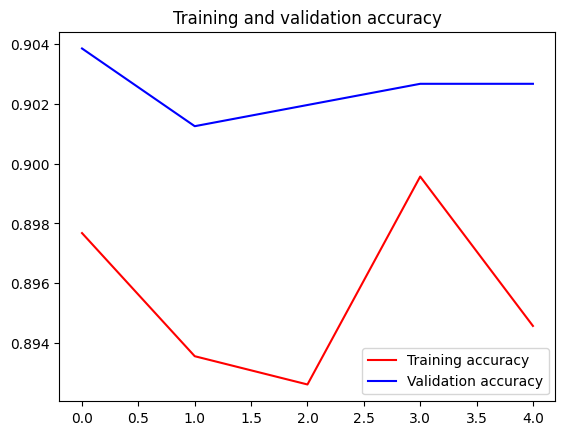

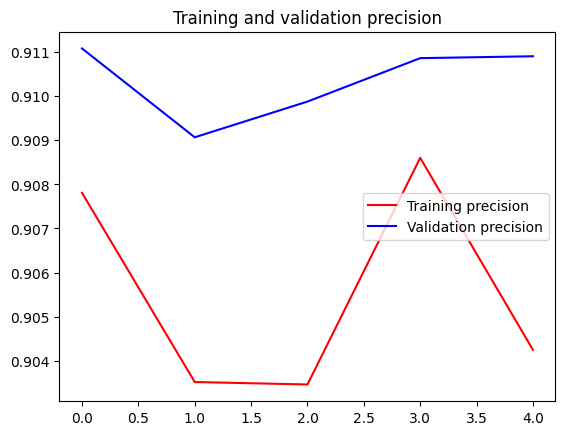

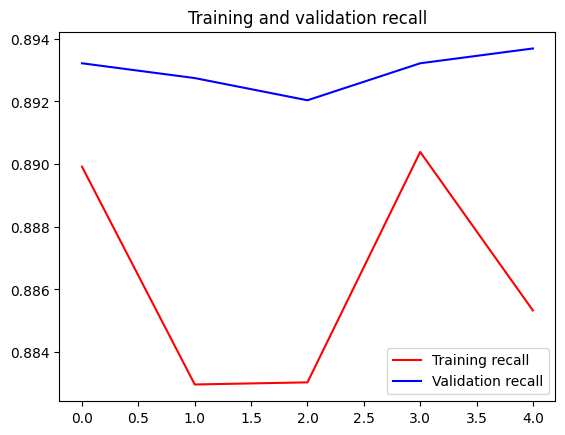

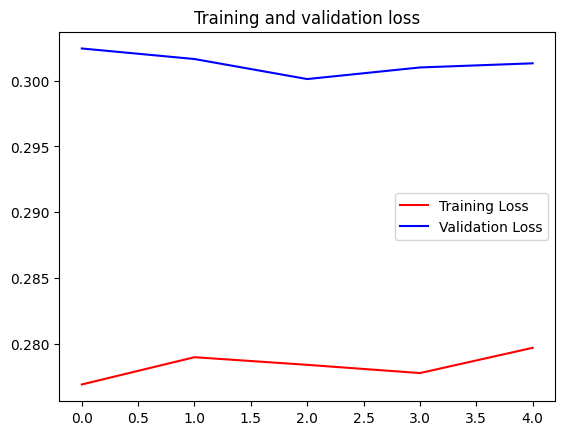

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
#model history
import pandas as pd
loss_df = pd.DataFrame(VGG16_MODEL.history.history)
loss_df

""


In [22]:
#prediction on test data
predictions = np.argmax(VGG16_MODEL.predict(test_set), axis = -1)

34/34 [==============================] - 10s 293ms/step


In [23]:
#classification report
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       362
           1       0.90      0.88      0.89       602
           2       0.90      0.93      0.92      1020
           3       0.98      0.87      0.92       135

    accuracy                           0.91      2119
   macro avg       0.92      0.89      0.91      2119
weighted avg       0.91      0.91      0.91      2119



In [24]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(test_set.classes, predictions)
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

[[321  13  27   1]
 [ 10 528  64   0]
 [ 22  45 951   2]
 [  2   0  15 118]]
sensitivity: 0.9611
specificity: 0.9814


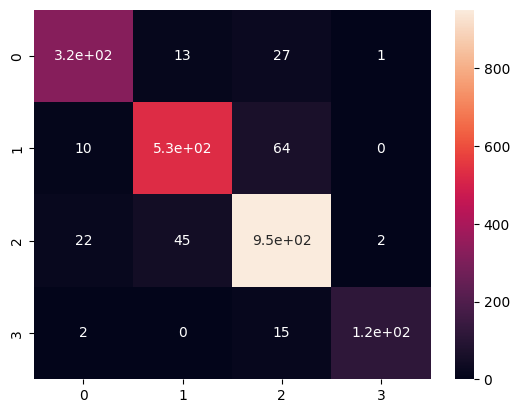

In [25]:
import seaborn as sns
print(confusion_matrix(test_set.classes,predictions))
sns.heatmap(confusion_matrix(test_set.classes,predictions), annot = True)
# show the sensitivity, and specificity
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [26]:
from numpy import sqrt
G_Mean = sqrt(sensitivity * specificity)
print("G_Mean: ", G_Mean)

G_Mean:  0.9711920221354235


In [27]:
True_Positive_Rate = cm[0, 0] / (cm[0, 0] + cm[0, 1])
False_Positive_Rate = cm[1, 0] / (cm[1, 0] + cm[1, 1])
print("True_Positive_Rate: {:.4f}".format(True_Positive_Rate))
print("False_Positive_Rate: {:.4f}".format(False_Positive_Rate))

True_Positive_Rate: 0.9611
False_Positive_Rate: 0.0186


In [28]:
print(test_set)
print(predictions)

[0 0 0 ... 3 3 3]


In [29]:
testsetTo = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print(testsetTo.shape)

(2119, 4)


In [30]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [31]:
#ROC-AUC Curve
# Learn to predict each class against the other
n_classes = 4
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresh = dict()
roc_auc = dict()
lw = 2
for i in range(n_classes):
    fpr[i], tpr[i], thresh[i] = roc_curve(np.argmax(testsetTo, axis=1), predictions, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [32]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresh[i] = roc_curve(np.argmax(testsetTo, axis=1), predictions, pos_label=i)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<ipython-input-33-8d057ad44288>:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


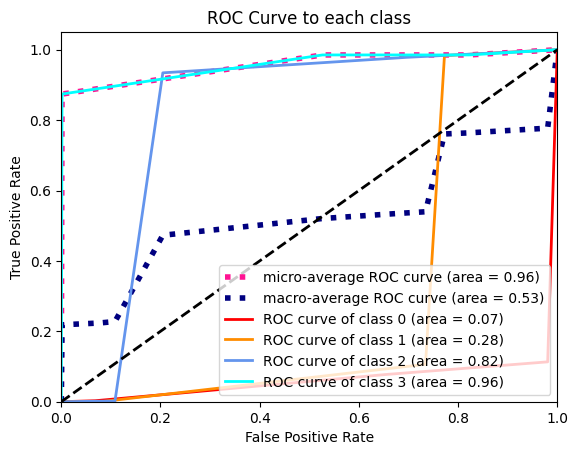

In [33]:
# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle
roc_auc_scores = []
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['red', 'darkorange', 'cornflowerblue', 'aqua'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    roc_auc_scores.append(roc_auc[i])

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve to each class')
plt.legend(loc="lower right")
plt.show()